#### Autor: Victor M. Fonte Chavez

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
torch.set_float32_matmul_precision('medium')

import torchvision as tv
from torchvision import transforms
from torchvision.datasets import ImageFolder

from torchmetrics import MetricCollection
from torchmetrics.classification.accuracy import Accuracy
from torchmetrics.classification.stat_scores import StatScores

from transformers import ViTForImageClassification

import lightning as pl

C:\Users\vfont\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vfont\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [14]:
torch.cuda.is_available()

True

### Trainer Class: Comun para todos los ejercicios

In [2]:
class TrainerFineTune(pl.LightningModule):
    def __init__(self, model, save_dir = None):
        super(TrainerFineTune, self).__init__()

        self.save_dir = save_dir
        self.n_classes = 102
        self.net = model
        # Congelado de todos los parámetros de la red excepto los de la capa clasificadora
        for name, param in self.net.named_parameters():
            if "classifier" not in name:
                param.requires_grad = False

        self.train_metrics = MetricCollection(
            {
                "train_acc": Accuracy(num_classes=self.n_classes, task="multiclass", top_k=1),
                "train_acc_top5": Accuracy(
                    num_classes=self.n_classes,
                    task="multiclass",
                    top_k=min(5, self.n_classes),
                ),
            }
        )
        self.val_metrics = MetricCollection(
            {
                "val_acc": Accuracy(num_classes=self.n_classes, task="multiclass", top_k=1),
                "val_acc_top5": Accuracy(
                    num_classes=self.n_classes,
                    task="multiclass",
                    top_k=min(5, self.n_classes),
                ),
            }
        )
        self.train_progress = {"loss": [], "acc": []}
        self.val_progress = {"loss": [], "acc": []}
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []

    def forward(self, x):
        return self.net(pixel_values=x).logits
    
    def training_step(self, batch, _):
        images, y = batch
        y = F.one_hot(y, num_classes=self.n_classes).float()
        
        self.log("lr", self.trainer.optimizers[0].param_groups[0]["lr"], prog_bar=True)

        y_hat = self.forward(images)
        loss = F.cross_entropy(y_hat, y.argmax(1))
        mets = self.train_metrics(y_hat, y.argmax(1))

        self.train_progress["loss"].append(loss.item())
        self.train_progress["acc"].append(100*mets["train_acc"].item())

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=False, sync_dist=True)
        with torch.inference_mode():
            for k, v in mets.items():
                self.log(k, 100*v, prog_bar=True, on_step=True, on_epoch=False, sync_dist=True)

        return loss

    @torch.no_grad()
    def validation_step(self, batch, _):
        images, y = batch
        y = F.one_hot(y, num_classes=self.n_classes).float()
        
        y_hat = self.forward(images)
        loss = torch.sum(-y * F.log_softmax(y_hat, dim=-1), dim=-1).mean()
        mets = self.val_metrics(y_hat, y.argmax(1))

        self.val_progress["loss"].append(loss.item())
        self.val_progress["acc"].append(100*mets["val_acc"].item())

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        for k, v in mets.items():
            self.log(k, 100*v, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
    
    @torch.no_grad()
    def on_train_epoch_end(self):
        self.train_loss.append(np.mean(self.train_progress["loss"]))
        self.val_loss.append(np.mean(self.val_progress["loss"]))
        self.train_acc.append(np.mean(self.train_progress["acc"]))
        self.val_acc.append(np.mean(self.val_progress["acc"]))

        self.train_progress["loss"].clear()
        self.val_progress["loss"].clear()
        self.train_progress["acc"].clear()
        self.val_progress["acc"].clear()

        if self.save_dir is not None:
            torch.save(self.net, os.path.join(self.save_dir, f"epoch_{self.current_epoch}.pth"))

        print(f"\nEpoch {self.current_epoch+1}/{self.trainer.max_epochs}", f"val_loss: {self.val_loss[-1]:.4f}", f"val_acc: {self.val_acc[-1]:.4f}")

    def configure_optimizers(self):
        lr = 1e-2
        optimizer = optim.AdamW(self.net.parameters(), lr=lr)
        scheduler = CosineAnnealingLR(
                    optimizer,
                    T_max=410,
                    eta_min=5e-5
                )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            }
        }

### Cargado de los datos

In [3]:
train_dir = '_data/train/'
valid_dir = '_data/valid/'

cat_to_name_file = os.path.join("_data", 'cat_to_name.json')

with open(cat_to_name_file, 'r') as f:
    cat_to_name = json.load(f)

In [4]:
size = 224
min_scale = 0.08
max_scale = 1.0
flip_prob = 0.5
rand_aug_n = 0
rand_aug_m = 9
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

batch_size = 32
n_classes = len(os.listdir(train_dir))

transforms_train = transforms.Compose(
    [
        transforms.RandomResizedCrop(
            (size, size),
            scale=(min_scale, max_scale),
        ),
        transforms.RandomHorizontalFlip(flip_prob),
        transforms.RandAugment(rand_aug_n, rand_aug_m),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)
transforms_val = transforms.Compose(
    [
        transforms.Resize(
            (size, size),
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

train_dataset = ImageFolder(root=train_dir, transform=transforms_train)
valid_dataset = ImageFolder(root=valid_dir, transform=transforms_val)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Usando un ViT pre-entrenado realizo el fine-tune sobre el conjunto de datos de
Flowers102 Flowers102 y replico el experimento de clasificación presentado en el paper de
ViT (Dosovitskiy et al., An Image is Worth 16x16 Words: Transformers for Image Recognition
at Scale)

En este caso guardamos el modelo para posteriores problemas 

In [6]:
trainer = pl.Trainer(
    max_epochs = 10,  
    devices=1,
    accelerator='gpu',
)

net = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224-in21k', 
            num_labels=102
        )

model = TrainerFineTune(net, save_dir='_checkpoints/teacher')
trainer.fit(model, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | net           | ViTForImageClassification | 85.9 M
1 | train_metrics | MetricCollection          | 0     
2 | val_metrics   | MetricCollection          | 0     
------------------------------------------------------------
78.4 K    Trainable params
85.8 M    Non-trainable params
85.9 M    Total params
343.508   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 205/205 [01:22<00:00,  2.48it/s, v_num=61, lr=0.00506, train_loss=0.0136, train_acc=100.0, train_acc_top5=100.0, val_loss=0.0407, val_acc=99.50, val_acc_top5=99.80]
Epoch 1/10 val_loss: 0.3678 val_acc: 92.8819
Epoch 1: 100%|██████████| 205/205 [01:19<00:00,  2.57it/s, v_num=61, lr=5.01e-5, train_loss=0.0739, train_acc=95.80, train_acc_top5=100.0, val_loss=0.0391, val_acc=99.40, val_acc_top5=99.80]  
Epoch 2/10 val_loss: 0.0414 val_acc: 99.3056
Epoch 2: 100%|██████████| 205/205 [01:21<00:00,  2.51it/s, v_num=61, lr=0.00499, train_loss=0.0529, train_acc=100.0, train_acc_top5=100.0, val_loss=0.0406, val_acc=99.40, val_acc_top5=99.90] 
Epoch 3/10 val_loss: 0.0445 val_acc: 99.2121
Epoch 3: 100%|██████████| 205/205 [01:19<00:00,  2.59it/s, v_num=61, lr=0.010, train_loss=0.00494, train_acc=100.0, train_acc_top5=100.0, val_loss=0.0401, val_acc=99.30, val_acc_top5=99.80]  
Epoch 4/10 val_loss: 0.0425 val_acc: 99.1854
Epoch 4: 100%|██████████| 205/205 [01:27<00:00,  2.3

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 205/205 [02:05<00:00,  1.63it/s, v_num=61, lr=5.01e-5, train_loss=0.0227, train_acc=100.0, train_acc_top5=100.0, val_loss=0.0362, val_acc=99.40, val_acc_top5=99.90]


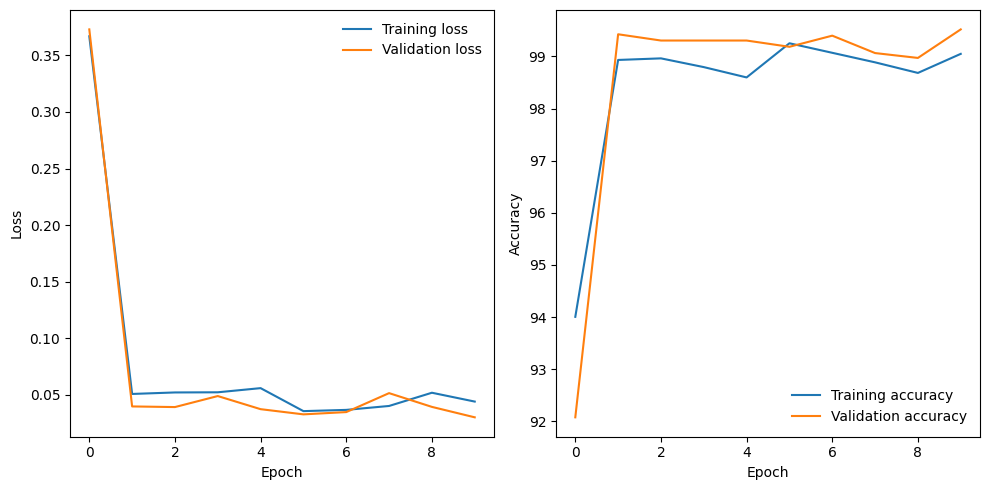

In [10]:
training_loss = model.train_loss
validation_loss = model.val_loss
training_acc = model.train_acc
validation_acc = model.val_acc

# Plot loss y accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(training_acc, label='Training accuracy')
plt.plot(validation_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()